In [5]:
import torch
from torch import Tensor

from sbi.analysis import pairplot
from sbi.inference import NPE, FMPE, SNPE, VIPosterior, simulate_for_sbi, NPE_A
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from src.data.profile_loader import *

import argparse


inference_method = 'NPE'
multi_round = False if inference_method == 'FMPE' else True
# multi_round = False
num_sims = 1000
sim_id = 777
num_rounds = 2


param_names, fiducial_values, maxdiff, minVal, maxVal = getParamsFiducial()


prior = BoxUniform(low=Tensor(minVal), high=Tensor(maxVal))
simulator = lambda x: getMeanProfilesParamsTensor(x, filterType='CAP', ptype='gas')[1]

theta_true =  torch.tensor(getParams(sim_id), dtype=torch.float32) # prior.sample((1,))
# generate our observation
x_obs = simulator(theta_true)


# Set up the inference method
if inference_method == "FMPE":
    inference = FMPE(prior=prior)
elif inference_method == "NPE":
    inference = NPE(prior=prior)
elif inference_method == "SNPE":
    inference = SNPE(prior=prior)

if multi_round:
    posteriors = []
    proposal = prior
    for r in range(num_rounds):
        theta, x = simulate_for_sbi(simulator, proposal, num_simulations=num_sims)
        density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
        # final_round = r == num_rounds - 1
        # density_estimator = inference.train(final_round=final_round)
        posterior = inference.build_posterior(density_estimator)
        posteriors.append(posterior)
        proposal = posterior.set_default_x(x_obs)
else:
    theta = prior.sample((num_sims,))
    x = simulator(theta)
    inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior()

Read 35 parameters from data/SB35_param_minmax.csv
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)



%|          | 0/1000 [00:00<?, ?it/s]

Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filte


%|▎         | 31/1000 [00:00<00:03, 306.20it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|▌         | 62/1000 [00:00<00:09, 94.60it/s] 
%|█         | 104/1000 [00:00<00:05, 160.86it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|█▍        | 148/1000 [00:00<00:03, 222.75it/s]
%|█▉        | 189/1000 [00:00<00:03, 267.68it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|██▎       | 231/1000 [00:00<00:02, 306.61it/s]
%|██▊       | 276/1000 [00:01<00:02, 343.58it/s]

Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP 


%|███▏      | 321/1000 [00:01<00:01, 371.14it/s]
%|███▋      | 363/1000 [00:01<00:01, 380.34it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|████      | 408/1000 [00:01<00:01, 399.07it/s]
%|████▌     | 453/1000 [00:01<00:01, 412.94it/s]

Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP 


%|████▉     | 498/1000 [00:01<00:01, 420.68it/s]
%|█████▍    | 542/1000 [00:01<00:01, 426.22it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|█████▉    | 588/1000 [00:01<00:00, 433.63it/s]
%|██████▎   | 636/1000 [00:01<00:00, 444.91it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|██████▊   | 685/1000 [00:02<00:00, 457.21it/s]
%|███████▎  | 735/1000 [00:02<00:00, 469.23it/s]

Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP 


%|███████▉  | 788/1000 [00:02<00:00, 485.34it/s]
%|████████▎ | 837/1000 [00:02<00:00, 484.38it/s]

Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filte


%|████████▊ | 886/1000 [00:02<00:00, 458.16it/s]
%|█████████▎| 934/1000 [00:02<00:00, 463.23it/s]

Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP 


100%|██████████| 1000/1000 [00:02<00:00, 375.27it/s]


Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


wing 1000 posterior samples:  62%|██████▏   | 622/1000 [00:01<00:00, 448.38it/s]
Drawing 1000 posterior samples: 1152it [00:02, 438.63it/s]                         

%|          | 0/1000 [00:00<?, ?it/s]
%|▍         | 48/1000 [00:00<00:01, 476.06it/s]

Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filte


%|▉         | 96/1000 [00:00<00:01, 457.05it/s]
%|█▍        | 145/1000 [00:00<00:01, 469.06it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|█▉        | 192/1000 [00:00<00:01, 463.67it/s]
%|██▍       | 245/1000 [00:00<00:01, 483.25it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|██▉       | 295/1000 [00:00<00:01, 486.99it/s]
%|███▌      | 350/1000 [00:00<00:01, 504.97it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|████      | 401/1000 [00:00<00:01, 505.00it/s]
%|████▌     | 455/1000 [00:00<00:01, 515.28it/s]

Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filte


%|█████     | 509/1000 [00:01<00:00, 522.68it/s]
%|█████▋    | 564/1000 [00:01<00:00, 529.49it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|██████▏   | 617/1000 [00:01<00:00, 521.08it/s]
%|██████▋   | 671/1000 [00:01<00:00, 524.17it/s]

Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP 


%|███████▎  | 731/1000 [00:01<00:00, 545.13it/s]
%|███████▉  | 788/1000 [00:01<00:00, 552.21it/s]

Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from


%|████████▍ | 849/1000 [00:01<00:00, 568.18it/s]
%|█████████ | 906/1000 [00:01<00:00, 565.56it/s]

Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filte


100%|██████████| 1000/1000 [00:01<00:00, 526.86it/s]


Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filter given parameters...
Getting mean gas profiles with CAP filter for 1 simulations...
Finished getting mean profiles from 1 simulations.
Output shape: (1, 21)
Getting gas profiles with CAP filte

In [ ]:
samples = posterior.sample((1000,))
fig, ax = pairplot(samples[:,:8],
         points=theta_true[:8].unsqueeze(0),
         figsize=(10, 10),
         labels=param_names[:8])
fig.savefig(f'{inference_method}_mean_profile.png')


wing 1000 posterior samples:   0%|          | 0/1000 [00:50<?, ?it/s]

In [ ]:
# Convert to VI posterior
vi_posterior = VIPosterior(
    potential_fn=posterior.potential_fn,  # or potential_
    prior=prior,
)

vi_posterior = vi_posterior.set_default_x(x_obs)

# Train the VI approximation
vi_posterior.train(
    x=x_obs,
    num_iterations=1000,  # adjust based on convergence
    learning_rate=1e-3,
    show_progress_bars=True
)

# Now sampling is much faster
samples = vi_posterior.sample((1000,)) 


%|          | 0/2000 [00:00<?, ?it/s]
mup phase, this may take a few seconds...:   0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
samples = posterior.sample((1000,),x=x_obs)

Drawing 1000 posterior samples: 1635it [00:00, 86254.79it/s]            


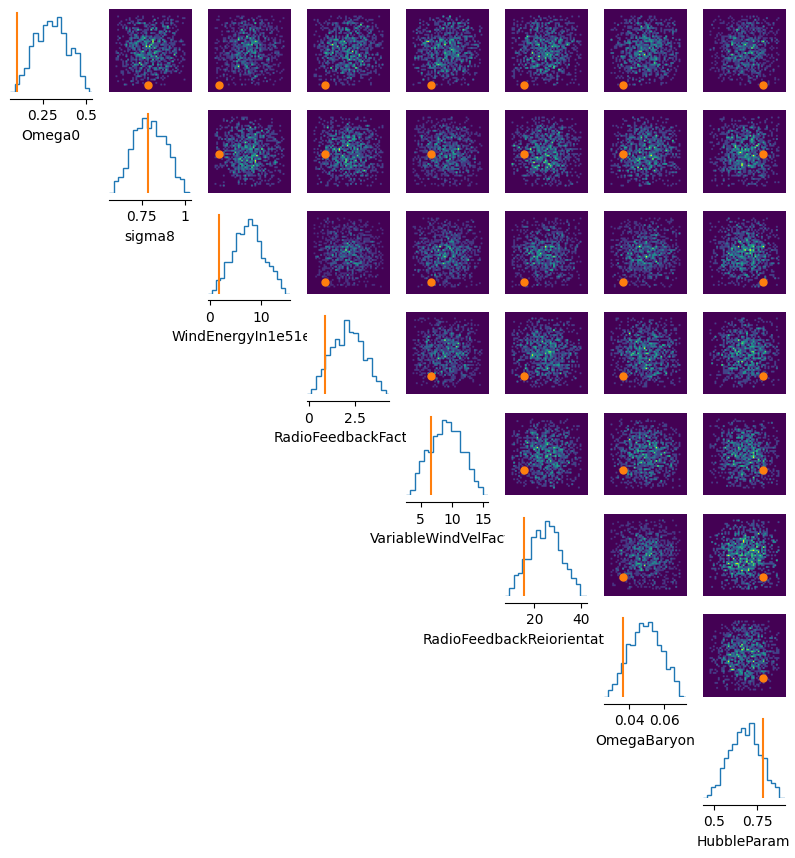

In [12]:
pairplot(samples[:,:8],
         points=theta_true[:8].unsqueeze(0),
         figsize=(10, 10),
         labels=param_names[:8]);

In [19]:
from sbi.inference import MCMCPosterior

mcmc_posterior = MCMCPosterior(
    potential_fn=posterior.potential_fn,
    proposal=prior,
    theta_transform=getattr(posterior, '_theta_transform', None)
)

samples = mcmc_posterior.sample(
    sample_shape=(1000,),  # or just (1000,)
    x=x_obs,
    num_chains=4,
    thin=1,
    warmup_steps=100,
    show_progress_bars=True
)

Running vectorized MCMC with 4 chains:   0%|          | 0/1600 [00:00<?, ?it/s]

KeyboardInterrupt: 